### Repeatable, Parallel Model Training and Model Tracking and Analysis  
  
In this notebook, you will use Azure Machine learning to create a repeatable, scaleable model training framework. Key concepts in this notebook are:  
  
1. **Data partition by column(s)**
   - In order to parallelize training by partition you will leverage the [data partition component](../src/components/partition_data/) to parse and send chunks of data to be trained.
   - In this case, data is partitioned by unique Store + Brand combinations
2. **Custom model training script**
   - The [model trianing script](../src/parallel_train.py) is custom and interchangeable so it can be easily adapted for changing needs
   -  In this case, the trianing script is a _very_ simple Gradient Boosted Regressor from scikit-learn
3. **Parallel model training on an ephermoral compute cluster**
   - The training utilizes the compute cluster from [Step 0 - Steup](./0_setup.ipynb) to train a model on each data partition in parallel
   - The cluster can be scaled vertically (node size) or horizontally (node count) as needed
   - The cluster is totally ephemoral - scaling down to zero running nodes when idle
4. **Azure Machine Learning Model Registry**
   - This notebook uses AML Model Registry to track model versions, artifacts, and metadata in a seamless and managed process
5. **MLflow alanysis across experiments and/or training jobs**
   - Using AML integration with MLFlow you are able to query models across experiments and/or training runs to analyze results
   - Building on this framework allows for a scaleable way to analyze 100,000+ models. Including answers to quesitons like:
     - Which model version has the lowest RMSE for a given Store/brand?
     - How do training and testing metrics compare between Experiment A and Experiment B?
     - How long on average did it take to train a model in Job 1?

In [1]:
# import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient, Input, Output, load_component
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.entities import Environment
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml.parallel import parallel_run_function, RunFunction
from dotenv import load_dotenv, find_dotenv
import os
import mlflow

In [2]:
# Initialize ML Client
load_dotenv(find_dotenv(), override=True)

# authenticate
credential = DefaultAzureCredential(tenantid=os.environ.get('TENANT_ID'))

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = os.environ.get('SUBSCRIPTION_ID'),
    resource_group_name = os.environ.get('RESOURCE_GROUP_NAME'),
    workspace_name = os.environ.get('WORKSPACE_NAME'),
)

### Create Azure ML Environment

In [3]:
# Create Environment
custom_env_name = "mm-remote-env-py37"

try:
    # let's see if the environment already exists
    env = ml_client.environments.get(custom_env_name, label="latest")
    print(f"You already have a environment named {custom_env_name}, we'll reuse it as is.")

except Exception:
    print("Creating a new environment...")
    custom_job_env = Environment(
        name=custom_env_name,
        description="Custom environment for many models",
        conda_file="../environment/remote_env_conda.yaml",
        image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04",
    )
    custom_job_env = ml_client.environments.create_or_update(custom_job_env)

    print(f"Environment created: {custom_job_env.name}")

ml_client.environments.get(custom_env_name, label="latest")

You already have a environment named mm-remote-env-py37, we'll reuse it as is.


Environment({'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'mm-remote-env-py37', 'description': 'Custom environment for many models', 'tags': {}, 'properties': {'azureml.labels': 'latest'}, 'print_as_yaml': True, 'id': '/subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourceGroups/many-models-rg/providers/Microsoft.MachineLearningServices/workspaces/mm-aml-wksp/environments/mm-remote-env-py37/versions/2', 'Resource__source_path': None, 'base_path': '/home/zacksoenen/Projects/many-models-azureml/demo_notebooks', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f5f2c1d36d0>, 'serialize': <msrest.serialization.Serializer object at 0x7f5f2c1d3890>, 'version': '2', 'latest_version': None, 'conda_file': {'channels': ['conda-forge'], 'dependencies': ['python=3.7.6', 'pip', {'pip': ['azureml-mlflow', 'mlflow', 'mltable>=1.2.0', 'azureml-dataset-runtime[pandas,fuse]', 'azureml-teleme

### Prepare, Define, and Run Training Pipeline

In [4]:
# Load data preparation component
partition_data = load_component(source="../src/components/partition_data/partition_data.yaml")

In [5]:
# Acess data asset
data_name = "oj-sim-sales-train"
train_data_asset = ml_client.data.get(data_name, label='latest')
print(train_data_asset.path)

azureml://subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourcegroups/many-models-rg/workspaces/mm-aml-wksp/datastores/workspaceblobstore/paths/LocalUpload/eabbea2d8b14c97a278f2f297b333403/train_subset.csv


In [6]:
# Define compute target (created in setup notebook)
cpu_compute_target = "mm-cpu-cluster"

In [7]:
# Declare parallel job, with a run_function task
many_model_training_with_partition_keys = parallel_run_function(
    name="distributed_training",
    display_name="Many Model Training",
    description="parallel job to train many models with partition_keys on mltable input",
    inputs=dict(
        data_source=Input(
            type=AssetTypes.MLTABLE,
            description="Input mltable with predefined partition format.",
            mode=InputOutputModes.DIRECT,  # [Important] To use 'partition_keys', input MLTable is required to use 'direct' mode.
        ),
        drop_cols=Input(
            type="string",
            description="Columns need to be dropped before training. Split by comma.",
        ),
        target_col=Input(
            type="string",
            description="The column name for label of the input data.",
        ),
        date_col=Input(
            type="string",
            description="The column name for datatime.",
        ),
    ),
    outputs=dict(
        model_folder=Output(
            type=AssetTypes.URI_FOLDER,
            mode=InputOutputModes.RW_MOUNT,
        )
    ),
    input_data="${{inputs.data_source}}",  # Define which input data will be splitted into mini-batches
    partition_keys=["Store","Brand"],  # Use 'partition_keys' as the data division method. This method requires MLTable input with partition setting pre-defined in MLTable artifact.
    instance_count=6,  # Use X nodes from compute cluster to run this parallel job.
    max_concurrency_per_instance=2,  # Create 2 worker processors in each compute node to execute mini-batches.
    error_threshold=-1,  # Monitor the failures of item processed by the gap between mini-batch input count and returns. 'Many model training' scenario doesn't fit this setting and '-1' means ignore counting failure items by mini-batch returns.
    mini_batch_error_threshold=5,  # Monitor the failed mini-batch by exception, time out, or null return. When failed mini-batch count is higher than this setting, the parallel job will be marked as 'failed'.
    retry_settings=dict(
        max_retries=1,  # Define how many retries when mini-batch execution is failed by exception, time out, or null return.
        timeout=60,  # Define the timeout in second for each mini-batch execution.
    ),
    logging_level="DEBUG", # DEBUG, INFO, WARNING, ERROR, ETC
    environment_variables={
        "AZUREML_PARALLEL_EXAMPLE": "1a_sdk",
    },
    task=RunFunction(
        code="../src/",
        entry_script="parallel_train.py",
        environment=ml_client.environments.get(custom_env_name, label="latest"),
        program_arguments="--drop_cols ${{inputs.drop_cols}} "  # Passthrough input parameters into parallel_train script.
        "--target_col ${{inputs.target_col}} "
        "--date_col ${{inputs.date_col}} "
        "--model_folder ${{outputs.model_folder}} ",
    ),
)

In [8]:
# Build Pipeline
# Declare the overall input of the job.
input_oj_data = Input(
    path=train_data_asset.path,
    type=AssetTypes.URI_FILE,
    mode=InputOutputModes.RO_MOUNT,
)

# Declare pipeline structure.
@pipeline(display_name="parallel train pipeline")
def parallel_training_pipeline(pipeline_input_data):
    
    # Declare 1st data partition command job.
    partition_job = partition_data(
        data_source=pipeline_input_data,
        partition_keys="Store,Brand",
    )

    # Declare 2nd parallel model training job.
    parallel_train = many_model_training_with_partition_keys(
        data_source=partition_job.outputs.tabular_output_data,
        drop_cols="Advert,Store,Brand",
        target_col="Revenue",
        date_col="WeekStarting",
    )
    
    # User could override parallel job run-level property when invoke that parallel job/component in pipeline.
    # parallel_train.resources.instance_count = 5
    # parallel_train.max_concurrency_per_instance = 2
    # parallel_train.mini_batch_error_threshold = 10

# Create pipeline instance
training_pipeline = parallel_training_pipeline(pipeline_input_data=input_oj_data,)

# Set pipeline level compute
training_pipeline.settings.default_compute = cpu_compute_target
print(training_pipeline)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


display_name: parallel train pipeline
type: pipeline
inputs:
  pipeline_input_data:
    mode: ro_mount
    type: uri_file
    path: azureml://subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourcegroups/many-models-rg/workspaces/mm-aml-wksp/datastores/workspaceblobstore/paths/LocalUpload/eabbea2d8b14c97a278f2f297b333403/train_subset.csv
jobs:
  partition_job:
    type: command
    inputs:
      data_source:
        path: ${{parent.inputs.pipeline_input_data}}
      partition_keys: Store,Brand
    component:
      $schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
      name: partition_data
      version: '1'
      display_name: Partition data by keys
      type: command
      inputs:
        data_source:
          type: uri_file
        partition_keys:
          type: string
      outputs:
        tabular_output_data:
          type: mltable
      command: python partition_data.py --data_source ${{inputs.data_source}} --partition_keys
        ${{inpu

In [9]:
# Submit training pipeline
pipeline_job = ml_client.jobs.create_or_update(
    training_pipeline,
    experiment_name="many-models-parallel-training-job-mlflow-full",
)


Uploading src (0.02 MBs): 100%|██████████| 15491/15491 [00:00<00:00, 91698.86it/s]




Navigate to the Portal to view pipeline progress. Wait for Pipeline to complete
  
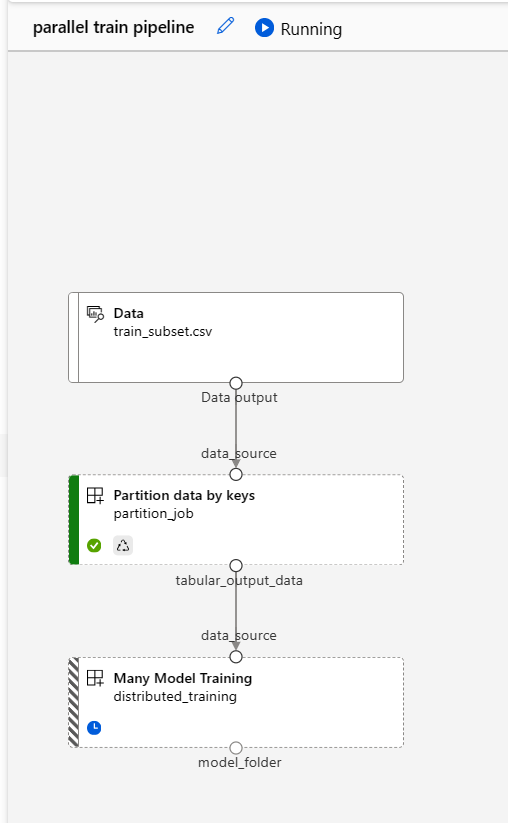

### Analyze Results using MLFlow

In [10]:
# Analyze results

azureml_tracking_uri = ml_client.workspaces.get(ml_client.workspace_name).mlflow_tracking_uri
mlflow.set_tracking_uri(azureml_tracking_uri)

EXPIREMENTS = ["many-models-parallel-training-job-mlflow-full"]

mlflow.search_runs(experiment_names= EXPIREMENTS,
                   filter_string="tags.store = '1013' and \
                                  metrics.test_mape < 30 and \
                                  tags.brand = 'tropicana' "
                )

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.training_r2_score,metrics.test_mape,metrics.training_score,metrics.training_rmse,...,params.random_state,params.max_leaf_nodes,tags.mlflow.rootRunId,tags.mlflow.parentRunId,tags.estimator_name,tags.store,tags.brand,tags.estimator_class,tags.mlflow.user,tags.mlflow.runName
0,dbc3c287-2aae-4667-b2c4-3f7a5a5028ac,329e77bf-7333-4509-9e23-a02ffa5437f8,FINISHED,,2024-01-08 19:36:08.547000+00:00,2024-01-08 19:36:17.536000+00:00,0.858681,15.432083,0.858681,3174.37721,...,12,None,sharp_hamster_flf5r7yz0v,5e532b7f-2c52-44ef-b082-e4358fea01cb,GradientBoostingRegressor,1013,tropicana,sklearn.ensemble.gradient_boosting.GradientBoo...,Zack Soenen,tropicana_1013_job
1,f5c1418d-7272-4cd3-901b-ad33b733514d,329e77bf-7333-4509-9e23-a02ffa5437f8,FINISHED,,2024-01-08 19:43:23.959000+00:00,2024-01-08 19:43:32.463000+00:00,0.858681,15.432083,0.858681,3174.37721,...,12,None,jolly_boniato_nlq8zt9qsp,f2051e72-8b30-4aa5-bcfe-dc2b523488b7,GradientBoostingRegressor,1013,tropicana,sklearn.ensemble.gradient_boosting.GradientBoo...,Zack Soenen,tropicana_1013_job
2,62433fc3-2b39-4621-b79d-ad826cd16b83,329e77bf-7333-4509-9e23-a02ffa5437f8,FINISHED,,2024-01-16 18:53:17.886000+00:00,2024-01-16 18:53:27.033000+00:00,0.858681,15.432083,0.858681,3174.37721,...,12,None,lime_lemon_htnxg5p3ly,5825094c-bcfe-4699-b96e-06b2928948f5,GradientBoostingRegressor,1013,tropicana,sklearn.ensemble.gradient_boosting.GradientBoo...,Zack Soenen,tropicana_1013_job


In [11]:
# Get best version of the registered
mlflow_client = mlflow.MlflowClient()
experiment_names=["many-models-parallel-training-job-mlflow30"]

experiment_ids = list(map(lambda x: mlflow_client.get_experiment_by_name(x).experiment_id, experiment_names))

# TODO: mlflow_client.search_runs() syntax to order by metrics.test_rmse
runs = mlflow_client.search_runs(experiment_ids = experiment_ids,
                               filter_string=f"tags.brand = 'dominicks' AND tags.store = '1000' AND attributes.status != 'FAILED'")

best_metric = -1
best_run = None
for r in runs:
    if best_metric == -1:
        best_metric = r.data.metrics['test_rmse']
        best_run = r.info.run_id
    else:
        if r.data.metrics['test_rmse'] < best_metric:
            best_metric = r.data.metrics['test_rmse']
            best_run = r.info.run_id

print(best_run)

model = mlflow_client.search_model_versions(filter_string=f"run_id = '{best_run}'")
print(model[0].version)

65dcfeea-aa57-4c83-80a4-6b1ee9ac8c9c
18
